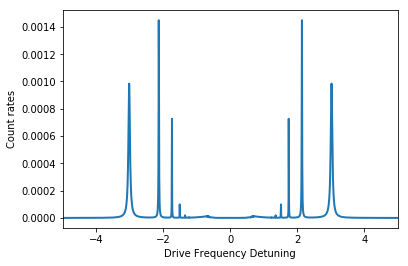

In [4]:
#
# Steady-state density matrix of a two-level atom in a high-Q
# cavity for various driving frequencies calculated using
# iterative 'steady' solver.
#
# Adapted from 'probss' example in the as functions of the detuning $\Delta_c$.
#
from qutip import *
from pylab import *
import scipy
import pandas as pd

def probss(E1, E2, kappa1, kappa2, gamma1, gamma2, gamma12, g1, g2, wc1, w31, w32, wc2, wl1, wl2, N1, N2):
    # construct composite operators
    ida = qeye(N1)
    ida = qeye(N2)
    idatom = qeye(3)
    sig13 = Qobj([[0, 0, 1],[0, 0, 0],[0, 0, 0]])
    sig31 = Qobj([[0, 0, 0],[0, 0, 0],[1, 0, 0]])
    sig23 = Qobj([[0, 0, 0],[0, 0, 1],[0, 0, 0]])
    sig32 = Qobj([[0, 0, 0],[0, 0, 0],[0, 1, 0]])
    sig12 = Qobj([[0, 1, 0],[0, 0, 0],[0, 0, 0]])
    sig21 = Qobj([[0, 0, 0],[1, 0, 0],[0, 0, 0]])
    sig33 = Qobj([[0, 0, 0],[0, 0, 0],[0, 0, 1]])
    sig22 = Qobj([[0, 0, 0],[0, 1, 0],[0, 0, 0]])
    
    a1 = tensor(destroy(N1), idatom)
    a2 = tensor(destroy(N2), idatom)
    s13 = tensor(ida, sig13)
    s31 = tensor(ida, sig31)
    s23 = tensor(ida, sig23)
    s32 = tensor(ida, sig32)
    s12 = tensor(ida, sig12)
    s21 = tensor(ida, sig21)
    s22 = tensor(ida, sig22)
    s33 = tensor(ida, sig33)
    
    # Hamiltonian
    H = (w31 - w31) * s13.dag() * s13 + (w31 - w31 - w32 + wl2) *  s23*s32 + (wc1 - wl1) * a1.dag() * a1 + \
       + (wc2 - wl2) * a2.dag() * a2 + g1 * (a1.dag() * s13 +  a1 * s13.dag()) + g2 * (a2.dag() * s23 +  a2 * s23.dag()) +\
    E1 * (a1.dag() + a1) +  E2 * (a2.dag() + a2)#+  E*(sm+sm.dag())#   

    # Collapse operators
    C1 = sqrt(2 * kappa1) * a1
    C2 = sqrt(2 * kappa2) * a2
    C3 = sqrt(2 * gamma1) * s13
    C4 = sqrt(2 * gamma2) * s32
    C5 = sqrt(2 * gamma2) * s12
    C1dC1 = C1.dag() * C1
    C2dC2 = C2.dag() * C2
    C3dC3 = C3.dag() * C3
    C4dC4 = C4.dag() * C4
    C5dC5 = C5.dag() * C5

    #method	‘direct’, ‘eigen’, ‘power’, ‘iterative-gmres’,’iterative-lgmres’, ‘svd’
    
    # find steady state
    rhoss = steadystate(H, [C1, C2, C3, C4, C5],use_precond=False, method='eigen',sparse=False,use_rcm = False, use_wbm=False,tol=1e-6)


    # calculate expectation values
    a1_dag_a1_e = expect(C1dC1, rhoss)
    a2_dag_a2_e = expect(C2dC2, rhoss)
    s33_e = expect(C3dC3, rhoss)
    s22_e = expect(C4dC4, rhoss)
    s13_e = expect(s13,rhoss)
    s23_e = expect(s23,rhoss)
    s12_e = expect(s12,rhoss)
    s13_a1_dag_e = expect(a1.dag()*s13,rhoss)
    s23_a2_dag_e = expect(a2.dag()*s23,rhoss)
    a1_e = expect(a1, rhoss)
    a2_e = expect(a2, rhoss)

    return a1_dag_a1_e, a2_dag_a2_e, s33_e, s22_e, s13_e, s23_e, s13_a1_dag_e, s23_a2_dag_e,  a1_e, a2_e


# setup the calculation
#-----------------------
# must be done before parfunc unless we
# want to pass all variables as one using
# zip function (see documentation for an example)
kappa1 = 0.001
kappa2 = 0.001
gamma1 = 0.001
gamma2 = 0.001
gamma12 = 0.00
g1 = 3.0
g2 = 0.05
wc1 = 0.0
w31 = 0.0
w32 = 0.0
wc2 = 0.0
wl2 = 0.0
N1 =30
N2 =30
E1 = 0.128
E2 = 0.128
nloop = 2000
wl1 = linspace(-5,5,nloop)

# define single-variable function for use in parfor
# cannot be defined inside run() since it needs to
# be passed into seperate threads.
def parfunc(wl1):  # function of wl only
    a1_dag_a1_e, a2_dag_a2_e, s33_e, s22_e, s13_e, s23_e, s13_a1_dag_e, s23_a2_dag_e,  a1_e, a2_e = \
    probss(E1, E2, kappa1, kappa2, gamma1, gamma2, gamma12, g1, g2, wc1, w31, w32, wc2, wl1, wl2, N1, N2)
    return a1_dag_a1_e, a2_dag_a2_e, s33_e, s22_e, s13_e, s23_e, s13_a1_dag_e, s23_a2_dag_e,  a1_e, a2_e

def run():
    # run parallel for-loop over wlist
    a1_dag_a1_e, a2_dag_a2_e, s33_e, s22_e, s13_e, s23_e, s13_a1_dag_e, s23_a2_dag_e,  a1_e, a2_e = parfor(parfunc, wl1)
    
   # column_titles = ['wl1', 'real(a1_dag_a1_e)', 'real(a2_dag_a2_e)', 'real(s33_e)', 'real(s22_e)',
   #                     'eal(s13_e)', 'mag(s13_e)', 'eal(s23_e)', 'mag(s23_e)', 'eal(s13_a1_dag_e)',
   #                     'mag(s13_a1_dag_e)', 'real(s23_a2_dag_e)', 'imag(s23_a2_dag_e)', 'real(a1_e) imag(a2_e)',
   #                     'real(a1_e)', 'imag(a1_e)', 'real(a2_e)','imag(a2_e)']
   # data  = pd.DataFrame(np.array([wl1, real(a1_dag_a1_e), real(a2_dag_a2_e), real(s33_e), real(s22_e),
   #                     real(s13_e), imag(s13_e), real(s23_e), imag(s23_e), real(s13_a1_dag_e),
   #                     imag(s13_a1_dag_e), real(s23_a2_dag_e), imag(s23_a2_dag_e), real(a1_e), imag(a2_e),
   #                     real(a1_e), imag(a1_e), real(a2_e),imag(a2_e)]),
   #                     columns=column_titles)
   # output_data=vstack((wlist,real(count1), imag(count1),real(count2), imag(count2),real(count3),imag(count3),real(sma),imag(sma), real(infield),imag(infield)))
    output_data=vstack((wl1, real(a1_dag_a1_e), real(a2_dag_a2_e), real(s33_e), real(s22_e), real(s13_e), imag(s13_e), real(s23_e), imag(s23_e), real(s13_a1_dag_e),imag(s13_a1_dag_e), real(s23_a2_dag_e), imag(s23_a2_dag_e), real(a1_e), imag(a2_e), real(a1_e), imag(a1_e), real(a2_e),imag(a2_e)))
    file_data_store('/home/photon/Dropbox/data/three_level_two_mode/data/three_level/vertical_scan12.dat',output_data.T,numtype="real",sep=",")
    
    # plot cavity emission and qubit spontaneous emssion
    fig = figure(1)
    ax = fig.add_subplot(111)
    #ax.plot(wlist, real(a_dag_a_e), lw=2)
    ax.plot(wl1, real(a2_dag_a2_e),lw=2)
    xlabel('Drive Frequency Detuning')
    ylabel('Count rates')
    xlim(-5,5)
    show()

if __name__ == "__main__":
   run()